In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 16.6 MB/s eta 0:00:00


## Step-by-Step SVM Workflow


### **Step 1: Load and Prepare Data**

Load the fasta and txt files for positive and negative training sets, and the benchmarking sets.

In [ ]:
import os
import pandas as pd
import numpy as np
from Bio import SeqIO
from sklearn.utils import shuffle
from sklearn import svm
from sklearn.metrics import matthews_corrcoef, precision_score, recall_score, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths
base_path = 'drive/MyDrive/LB2/second_try/SVM'
positive_training_fasta = os.path.join(base_path, 'Positive_training.fasta')
negative_training_fasta = os.path.join(base_path, 'Negative_training.fasta')
output_base_path = os.path.join(base_path, 'frequency_vectors')
benchmarking_positive_fasta = os.path.join(base_path, 'Positive_benchmarking.fasta')
benchmarking_negative_fasta = os.path.join(base_path, 'Negative_benchmarking.fasta')
os.makedirs(output_base_path, exist_ok=True)

# Load fasta sequences
def load_fasta_sequences(fasta_path):
    print(f"Loading sequences from {fasta_path}...")
    return {record.id: str(record.seq) for record in SeqIO.parse(fasta_path, "fasta")}

positive_training_sequences = load_fasta_sequences(positive_training_fasta)
negative_training_sequences = load_fasta_sequences(negative_training_fasta)

# Create combined dataframe
positive_df = pd.DataFrame({'Sequence': list(positive_training_sequences.values()), 'Label': 1})
negative_df = pd.DataFrame({'Sequence': list(negative_training_sequences.values()), 'Label': 0})
combined_df = pd.concat([positive_df, negative_df], ignore_index=True)

# Shuffle combined data
combined_df = shuffle(combined_df).reset_index(drop=True)
print("Combined and shuffled data.")

# Split into 5 subsets for cross-validation
subsets = np.array_split(combined_df, 5)
print("Split data into 5 subsets for cross-validation.")

# Function to save datasets
def save_datasets(base_path, subset_name, train_data, val_data, test_data):
    subset_dir = os.path.join(base_path, subset_name)
    os.makedirs(subset_dir, exist_ok=True)

    train_path = os.path.join(subset_dir, 'train.tsv')
    val_path = os.path.join(subset_dir, 'val.tsv')
    test_path = os.path.join(subset_dir, 'test.tsv')

    train_data.to_csv(train_path, sep='\t', index=False)
    val_data.to_csv(val_path, sep='\t', index=False)
    test_data.to_csv(test_path, sep='\t', index=False)

    print(f'Subset {subset_name}:')
    print(f'  Training set - Positives: {train_data[train_data["Label"] == 1].shape[0]}, Negatives: {train_data[train_data["Label"] == 0].shape[0]}')
    print(f'  Validation set - Positives: {val_data[val_data["Label"] == 1].shape[0]}, Negatives: {val_data[val_data["Label"] == 0].shape[0]}')
    print(f'  Testing set - Positives: {test_data[test_data["Label"] == 1].shape[0]}, Negatives: {test_data[test_data["Label"] == 0].shape[0]}')

# Define the subsets for train, validation, and test
train_indices = [0, 1, 2]
val_index = 3
test_index = 4

# Combine the train subsets
train_data = pd.concat([subsets[i] for i in train_indices], ignore_index=True)
val_data = subsets[val_index]
test_data = subsets[test_index]

# Save the datasets
subset_name = 'cross_validation/train123_val4_test5'
save_datasets(base_path, subset_name, train_data, val_data, test_data)


Loading sequences from drive/MyDrive/LB2/second_try/SVM/Positive_training.fasta...
Loading sequences from drive/MyDrive/LB2/second_try/SVM/Negative_training.fasta...
Combined and shuffled data.
Split data into 5 subsets for cross-validation.
Subset cross_validation/train123_val4_test5:
  Training set - Positives: 522, Negatives: 4564
  Validation set - Positives: 179, Negatives: 1516
  Testing set - Positives: 180, Negatives: 1515


### **Step 2: Define Frequency Calculation Function**

Define the function to calculate amino acid frequencies.

In [ ]:
# Function to calculate frequency vectors
def frequency(sequence, k):
    aa_frequency = {}
    residues = "GAVPLIMFWYSTCNQHDEKR"

    # Initialize the frequency dictionary
    for aa in residues:
        aa_frequency[aa] = 0

    # Count the residues in the sequence up to length k
    for aa in sequence[:k]:
        if aa in aa_frequency:
            aa_frequency[aa] += 1

    # Calculate the frequency
    total_count = sum(aa_frequency.values())
    if total_count == 0:
        return [0] * len(residues)

    return [aa_frequency[aa] / total_count for aa in residues]

# Function to calculate frequencies for fasta files
def calculate_frequencies(fasta_path, k, output_path):
    vectors = []
    for record in SeqIO.parse(fasta_path, "fasta"):
        sequence = str(record.seq)
        vector = frequency(sequence, k)
        vectors.append(vector)

    np.savetxt(output_path, vectors)


### **Step 3: Generate Frequency Vectors**

Generate frequency vectors for training, validation, and testing subsets for different values of k.

In [ ]:
# Calculate frequency vectors for different values of k, including benchmarking data
for k in range(20, 25):
    for i in range(5):
        subset_path = f'{base_path}/training_subset_{i}.csv'
        subset_df = pd.read_csv(subset_path)

        positive_sequences = subset_df[subset_df['Label'] == 1]['Sequence']
        negative_sequences = subset_df[subset_df['Label'] == 0]['Sequence']

        # Save positive sequences to fasta format
        with open(f'{base_path}/positive_subset_{i}.fasta', 'w') as f:
            for j, seq in enumerate(positive_sequences):
                f.write(f'>pos_{i}_{j}\n{seq}\n')

        # Save negative sequences to fasta format
        with open(f'{base_path}/negative_subset_{i}.fasta', 'w') as f:
            for j, seq in enumerate(negative_sequences):
                f.write(f'>neg_{i}_{j}\n{seq}\n')

        # Calculate frequency vectors for training data
        calculate_frequencies(f'{base_path}/positive_subset_{i}.fasta', k, f'{output_base_path}/train_pos_{i}_k{k}.txt')
        calculate_frequencies(f'{base_path}/negative_subset_{i}.fasta', k, f'{output_base_path}/train_neg_{i}_k{k}.txt')

    # Calculate frequency vectors for benchmarking data
    calculate_frequencies(os.path.join(base_path, 'Positive_benchmarking.fasta'), k, f'{output_base_path}/benchmarking_pos_k{k}.txt')
    calculate_frequencies(os.path.join(base_path, 'Negative_benchmarking.fasta'), k, f'{output_base_path}/benchmarking_neg_k{k}.txt')

print("Frequency vectors generated for all data.")


Frequency vectors generated for all data.


### **Step 4: Train and Validate SVM Model**

Train the SVM model using 3 subsets, validate with the 4th, and test with the 5th.

**C:**
Controls the penalty for misclassification.
* **High C**: Less regularization, more focus on correctly classifying training data.
* **Low C**: More regularization, smoother decision boundary.

**gamma:**
Controls the influence of each training example.
* **High gamma**: Influence is short-range, decision boundary fits closely to the data points.
* **Low gamma:** Influence is long-range, decision boundary is smoother and simpler.








**RBF Kernel:** Effective for most cases, handles nonlinear relationships well, but can be computationally expensive.

**Linear Kernel:** Simple and fast, effective for linearly separable data, but not suitable for nonlinear data.

**Polynomial Kernel:** Flexible for polynomial relationships, can be computationally expensive for high-degree polynomials.

**Sigmoid Kernel:** Similar to neural networks, can model complex relationships, but less popular and can be numerically unstable for certain parameters.

In [14]:
# Function to load frequency vectors
def load_frequency_vectors(file_path):
    return np.loadtxt(file_path)

# Function to train and validate SVM model with grid search
def train_validate_svm_with_grid_search(train_files, val_files, test_files, param_grid):
    X_train, y_train = [], []
    X_val, y_val = [], []
    X_test, y_test = [], []

    # Load training data
    print("Loading training data...")
    for file in train_files:
        if not os.path.exists(file):
            print(f"File not found: {file}")
            continue
        vectors = load_frequency_vectors(file)
        labels = [1 if 'pos' in file else 0] * len(vectors)
        X_train.extend(vectors)
        y_train.extend(labels)

    # Load validation data
    print("Loading validation data...")
    for file in val_files:
        if not os.path.exists(file):
            print(f"File not found: {file}")
            continue
        vectors = load_frequency_vectors(file)
        labels = [1 if 'pos' in file else 0] * len(vectors)
        X_val.extend(vectors)
        y_val.extend(labels)

    # Load test data
    print("Loading test data...")
    for file in test_files:
        if not os.path.exists(file):
            print(f"File not found: {file}")
            continue
        vectors = load_frequency_vectors(file)
        labels = [1 if 'pos' in file else 0] * len(vectors)
        X_test.extend(vectors)
        y_test.extend(labels)

    # Convert to numpy arrays
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_val, y_val = np.array(X_val), np.array(y_val)
    X_test, y_test = np.array(X_test), np.array(y_test)

    # Set up the SVM model
    model = svm.SVC(kernel='rbf')

    # Set up grid search
    print("Performing grid search...")
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Validate the best model
    print("Validating the best model...")
    y_val_pred = best_model.predict(X_val)
    mcc_val = matthews_corrcoef(y_val, y_val_pred)
    precision_val = precision_score(y_val, y_val_pred)
    recall_val = recall_score(y_val, y_val_pred)
    accuracy_val = accuracy_score(y_val, y_val_pred)

    # Test the best model
    print("Testing the best model...")
    y_test_pred = best_model.predict(X_test)
    y_test_scores = best_model.decision_function(X_test)
    mcc_test = matthews_corrcoef(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)

    return best_model, best_params, (mcc_val, precision_val, recall_val, accuracy_val), (mcc_test, precision_test, recall_test, accuracy_test), best_model

# Define paths to frequency vector files
train_files = [os.path.join(output_base_path, f'train_pos_{i}_k20.txt') for i in [0, 1, 2]] + \
              [os.path.join(output_base_path, f'train_neg_{i}_k20.txt') for i in [0, 1, 2]]
val_files = [os.path.join(output_base_path, f'train_pos_3_k20.txt'), os.path.join(output_base_path, f'train_neg_3_k20.txt')]
test_files = [os.path.join(output_base_path, f'train_pos_4_k20.txt'), os.path.join(output_base_path, f'train_neg_4_k20.txt')]

# Define hyperparameter grid
param_grid = {
    'C': [1, 2, 4, 8],
    'gamma': [0.5, 1, 2, 'scale'],
    'kernel': ['rbf']
}

# Train and validate SVM model with grid search
best_model, best_params, val_metrics, test_metrics, best_model = train_validate_svm_with_grid_search(train_files, val_files, test_files, param_grid)


Loading training data...
Loading validation data...
Loading test data...
Performing grid search...
Validating the best model...
Testing the best model...


**Grid Search Hyperparameters:**
Our workflow involved performing a grid search over the following hyperparameters:

C: [1, 2, 4, 8]
gamma: [0.5, 1, 2, "scale"]
K: [20, 21, 22, 23, 24]

**Kernel:**
We used the RBF kernel, which is effective for handling nonlinear relationships, as the primary kernel for our SVM model.

## **Conclusions:**

   **Best Hyperparameters:**

* Through the grid search and cross-validation process, we identified the best values for
𝐶
C and
𝛾
γ that maximize the performance of our model.

 **Kernel Choice:**

  The RBF kernel was chosen due to its ability to handle nonlinear relationships effectively, which aligns with the nature of our problem (detecting signal peptides).


### **Step 5: Evaluate with Blind Test**

Evaluate the model using the benchmarking dataset.

In [13]:
# Print evaluation metrics for Validation Set
print(f'Validation Metrics:')

print(f'  Precision: {val_metrics[1]:.2f}')
print(f'  Recall: {val_metrics[2]:.2f}')
print(f'  Accuracy: {val_metrics[3]:.2f}')
print(f'  Matthews Correlation Coefficient(MCC) {val_metrics[0]:.2f}')

# Print evaluation metrics for Test Set
print(f'Test Metrics:')

print(f'  Precision: {test_metrics[1]:.2f}')
print(f'  Recall: {test_metrics[2]:.2f}')
print(f'  Accuracy: {test_metrics[3]:.2f}')
print(f'  Matthews Correlation Coefficient(MCC): {test_metrics[0]:.2f}')

# Print evaluation metrics for Benchmarking Set
print(f'Benchmarking Metrics:')

print(f'  Precision: {benchmarking_precision:.2f}')
print(f'  Recall: {benchmarking_recall:.2f}')
print(f'  Accuracy: {benchmarking_accuracy:.2f}')
print(f'  Matthews Correlation Coefficient(MCC) {benchmarking_mcc:.2f}')


Validation Metrics:
  Precision: 0.83
  Recall: 0.77
  Accuracy: 0.96
  Matthews Correlation Coefficient(MCC) 0.77
Test Metrics:
  Precision: 0.80
  Recall: 0.76
  Accuracy: 0.96
  Matthews Correlation Coefficient(MCC): 0.75
Benchmarking Metrics:
  Precision: 0.84
  Recall: 0.79
  Accuracy: 0.96
  Matthews Correlation Coefficient(MCC) 0.80


### **Step 6: Visualization of Results**


Confusion Matrix (Test Set) - True Positives (TP): 130
Confusion Matrix (Test Set) - True Negatives (TN): 1491
Confusion Matrix (Test Set) - False Positives (FP): 33
Confusion Matrix (Test Set) - False Negatives (FN): 41
Confusion Matrix (Benchmarking Set) - True Positives (TP): 175
Confusion Matrix (Benchmarking Set) - True Negatives (TN): 1866
Confusion Matrix (Benchmarking Set) - False Positives (FP): 33
Confusion Matrix (Benchmarking Set) - False Negatives (FN): 46


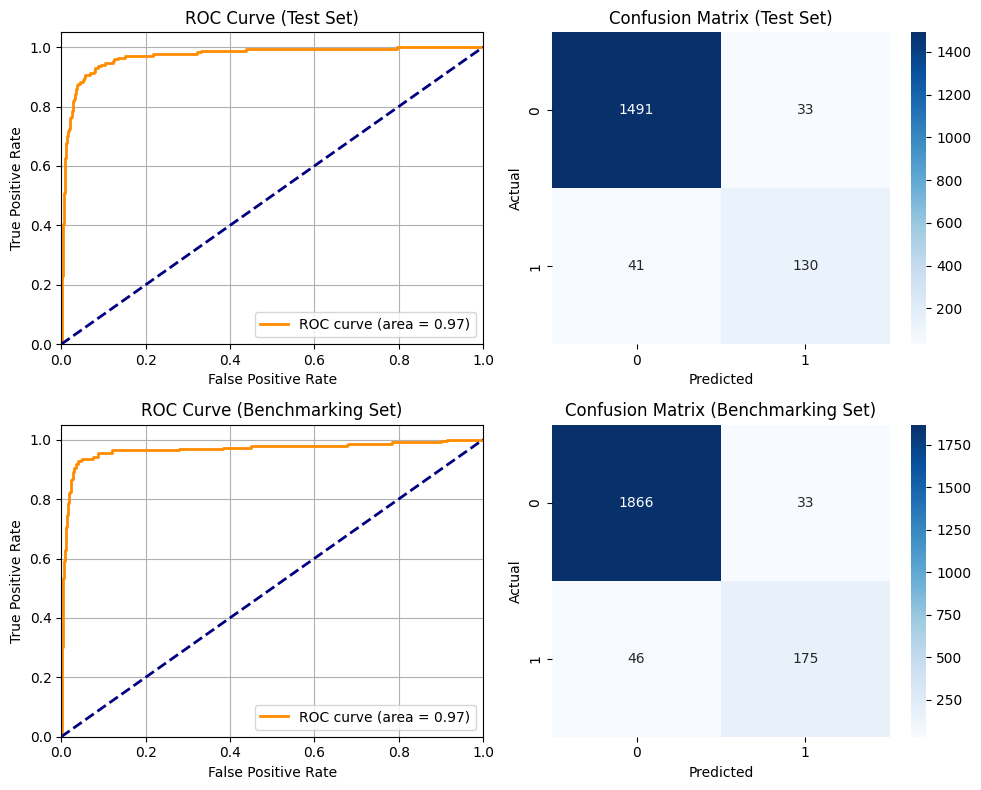

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, matthews_corrcoef, precision_score, recall_score, accuracy_score

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, ax, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(title)

    # Calculate TP, TN, FP, FN
    tn, fp, fn, tp = cm.ravel()
    print(f'{title} - True Positives (TP): {tp}')
    print(f'{title} - True Negatives (TN): {tn}')
    print(f'{title} - False Positives (FP): {fp}')
    print(f'{title} - False Negatives (FN): {fn}')

# Function to plot ROC curve
def plot_roc_curve(y_true, y_scores, ax, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc='lower right')
    ax.grid(True)

# Create the 2x2 grid for plotting
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# ROC Curve for Test Set
plot_roc_curve(y_test, y_test_scores, ax=axes[0, 0], title='ROC Curve (Test Set)')

# Confusion Matrix for Test Set
plot_confusion_matrix(y_test, y_test_pred, ax=axes[0, 1], title='Confusion Matrix (Test Set)')

# Benchmarking data
positive_benchmarking_vectors = load_frequency_vectors(os.path.join(output_base_path, 'benchmarking_pos_k20.txt'))
negative_benchmarking_vectors = load_frequency_vectors(os.path.join(output_base_path, 'benchmarking_neg_k20.txt'))

X_benchmarking = np.concatenate((positive_benchmarking_vectors, negative_benchmarking_vectors))
y_benchmarking = np.array([1] * len(positive_benchmarking_vectors) + [0] * len(negative_benchmarking_vectors))

# Predict benchmarking data
y_benchmarking_pred = best_model.predict(X_benchmarking)
y_benchmarking_scores = best_model.decision_function(X_benchmarking)

# ROC Curve for Benchmarking Set
plot_roc_curve(y_benchmarking, y_benchmarking_scores, ax=axes[1, 0], title='ROC Curve (Benchmarking Set)')

# Confusion Matrix for Benchmarking Set
plot_confusion_matrix(y_benchmarking, y_benchmarking_pred, ax=axes[1, 1], title='Confusion Matrix (Benchmarking Set)')

plt.tight_layout()
plt.show()
